# Identification of an electromechanical system

Example created by Wilson Rocha Lacerda Junior

More details about this data can be found in the following paper (in Portuguese): https://www.researchgate.net/publication/320418710_Identificacao_de_um_motorgerador_CC_por_meio_de_modelos_polinomiais_autorregressivos_e_redes_neurais_artificiais

In [ ]:
pip install sysidentpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

In [2]:
df1 = pd.read_csv("examples/datasets/x_cc.csv")
df2 = pd.read_csv("examples/datasets/y_cc.csv")

<AxesSubplot:>

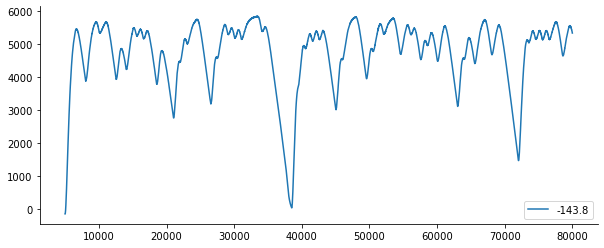

In [3]:
df2[5000:80000].plot(figsize=(10, 4))

In [4]:
# we will decimate the data using d=500 in this example
x_train, x_valid = np.split(df1.iloc[::500].values, 2)
y_train, y_valid = np.split(df2.iloc[::500].values, 2)

## Building a Polynomial NARX model

In [5]:
basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=40,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    info_criteria="bic",
    estimator="recursive_least_squares",
    basis_function=basis_function,
)

c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 15
  self.info_values = self.information_criterion(reg_matrix, y)


0.07912218629573997
       Regressors   Parameters             ERR
0          y(k-1)   1.3016E+00  9.86000384E-01
1       x1(k-1)^2   1.0393E+02  7.94805130E-03
2        y(k-2)^2   1.6288E-05  2.50905908E-03
3   x1(k-1)y(k-1)  -1.2567E-01  1.43301039E-03
4          y(k-2)  -5.0784E-01  1.02781443E-03
5   x1(k-1)y(k-2)   5.6049E-02  5.35200312E-04
6         x1(k-2)   3.4986E+02  2.79648078E-04
7   x1(k-2)y(k-1)  -8.4030E-02  1.12211942E-04
8  x1(k-2)x1(k-1)  -7.8186E+00  4.54743448E-05
9   x1(k-2)y(k-2)   3.4050E-02  3.25346101E-05


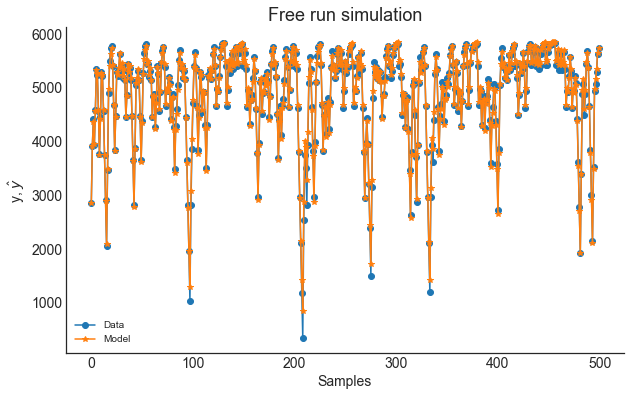

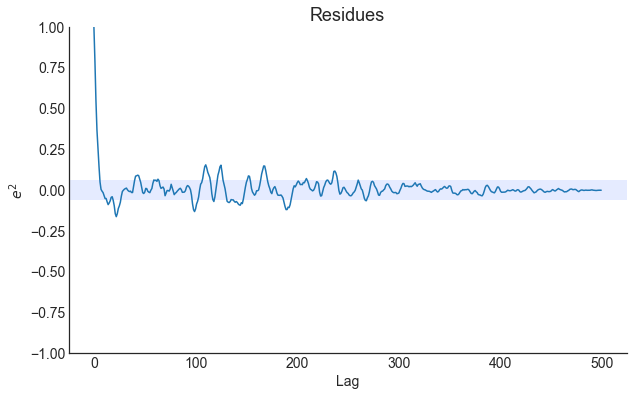

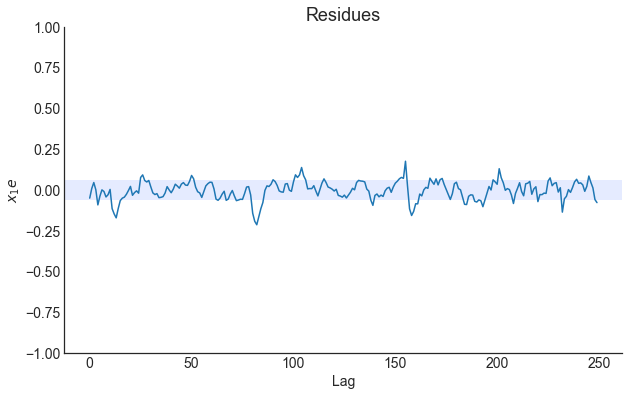

In [6]:
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

## Testing different autoregressive models

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
)
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from sysidentpy.general_estimators import NARX

basis_function = Polynomial(degree=2)


estimators = [
    (
        "KNeighborsRegressor",
        NARX(
            base_estimator=KNeighborsRegressor(),
            xlag=10,
            ylag=10,
            basis_function=basis_function,
            model_type="NARMAX",
        ),
    ),
    (
        "NARX-DecisionTreeRegressor",
        NARX(
            base_estimator=DecisionTreeRegressor(),
            xlag=10,
            ylag=10,
            basis_function=basis_function,
        ),
    ),
    (
        "NARX-RandomForestRegressor",
        NARX(
            base_estimator=RandomForestRegressor(n_estimators=200),
            xlag=10,
            ylag=10,
            basis_function=basis_function,
        ),
    ),
    (
        "NARX-Catboost",
        NARX(
            base_estimator=CatBoostRegressor(
                iterations=800, learning_rate=0.1, depth=8
            ),
            xlag=10,
            ylag=10,
            basis_function=basis_function,
            fit_params={"verbose": False},
        ),
    ),
    (
        "NARX-ARD",
        NARX(
            base_estimator=ARDRegression(),
            xlag=10,
            ylag=10,
            basis_function=basis_function,
        ),
    ),
    (
        "FROLS-Polynomial_NARX",
        FROLS(
            order_selection=True,
            n_info_values=50,
            extended_least_squares=False,
            ylag=10,
            xlag=10,
            info_criteria="bic",
            estimator="recursive_least_squares",
            basis_function=basis_function,
        ),
    ),
]

resultados = {}
for nome_do_modelo, modelo in estimators:
    resultados["%s" % (nome_do_modelo)] = []
    modelo.fit(X=x_train, y=y_train)
    yhat = modelo.predict(X=x_valid, y=y_valid)
    result = root_relative_squared_error(
        y_valid[modelo.max_lag :], yhat[modelo.max_lag :]
    )
    resultados["%s" % (nome_do_modelo)].append(result)
    print(nome_do_modelo, "%.3f" % np.mean(result))

c:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


KNeighborsRegressor 1.178
NARX-DecisionTreeRegressor 0.263
NARX-RandomForestRegressor 0.226
NARX-Catboost 0.159
NARX-ARD 0.072
FROLS-Polynomial_NARX 0.046


In [8]:
for aux_results, results in sorted(
    resultados.items(), key=lambda x: np.mean(x[1]), reverse=False
):
    print(aux_results, np.mean(results))

FROLS-Polynomial_NARX 0.045954494047661276
NARX-ARD 0.07153877637255217
NARX-Catboost 0.15909412163898615
NARX-RandomForestRegressor 0.22640167414558635
NARX-DecisionTreeRegressor 0.2631297612484716
KNeighborsRegressor 1.17783796557386
